In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import bambi as bmb
import theano
import arviz as az
import os
cwd = os.getcwd() # Get direction
import warnings
warnings.filterwarnings('ignore')
import bayes_ame as ame
import bayes_r2 as r2

In [2]:
DF= pd.read_csv(cwd[:-4]+'/Data/data_farmclass_state.csv')

In [3]:
DF.loc[DF.insured_farms > 1, 'insured_farms'] = 1
DF['midpoint_farmsize']= (DF['lower_bound']+DF['upper_bound'])/2
DF.loc[DF['livestockfarm_share']== 0.0, 'livestockfarm_share']= 0.0010
DF.loc[DF['irrigated_farms']== 1.0, 'irrigated_farms']= 0.99

In [4]:
def dfsummary(trace):
    dfy= az.summary(trace)
    dfy['variables'] =dfy.index
    dfy['farm_class']= dfy.variables.str[-2:-1]
    
    return dfy

### Prepare data for Bayesian Models

In [5]:
## Remove inf vals
DF.replace([np.inf, -np.inf], np.nan, inplace=True)
## Selected variables for inference
norm_vars= ['midpoint_farmsize',
            'insured_farms','fed_income','state_income',
            'rented_land','labor_share','machinery_asset',
             'livestockfarm_share',
             'cropland_entropy','cropland_share',
              'erosion_rate', 'climate_ffp_full_year','climate_ffp_z_full_year',
              'climate_prec_growing_season','climate_prec_z_full_year']
DF1= DF[['year','Region_fips','farm_class','class','tile_num','year_2017']+norm_vars]

## Standardize the complete sample except climate z values
for x in norm_vars:
    if x== 'climate_ffp_z_full_year' or x=='climate_prec_z_full_year':
        DF1[x+'_norm']= DF1[x]
    else:
        DF1[x+'_norm']= (np.log(DF1[x])- (np.log(DF1[x])).mean())/(np.log(DF1[x]).std())


# Pooled model

In [6]:
# Priors
priorsp = {
    'Intercept': bmb.Prior("Normal", mu= 0, sigma= 10),
    'midpoint_farmsize_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'insured_farms_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'fed_income_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'state_income_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'rented_land_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'machinery_asset_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'livestockfarm_share_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'cropland_entropy_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'cropland_share_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'erosion_rate_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'climate_ffp_full_year_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'climate_prec_growing_season_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'climate_ffp_z_full_year_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'climate_prec_z_full_year_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'year_2017': bmb.Prior('Laplace', mu= 0, b= 10)
}
## Pooled model
modelp = bmb.Model("tile_num ~ 1+(midpoint_farmsize_norm)+\
                    (insured_farms_norm)+(fed_income_norm) + (state_income_norm)+\
                    (rented_land_norm)+(machinery_asset_norm)+\
                     (livestockfarm_share_norm) + \
                    (cropland_entropy_norm)+(cropland_share_norm)+\
                     (erosion_rate_norm) + (climate_ffp_full_year_norm) +\
                    (climate_prec_growing_season_norm)+(climate_ffp_z_full_year_norm)+\
                    (climate_prec_z_full_year_norm)+\
                    (year_2017)", 
                     DF1, family='beta', priors= priorsp, dropna=True)

Automatically removing 274/1146 rows from the dataset.


In [7]:
tracep = modelp.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tile_num_kappa, Intercept, year_2017, climate_prec_z_full_year_norm, climate_ffp_z_full_year_norm, climate_prec_growing_season_norm, climate_ffp_full_year_norm, erosion_rate_norm, cropland_share_norm, cropland_entropy_norm, livestockfarm_share_norm, machinery_asset_norm, rented_land_norm, state_income_norm, fed_income_norm, insured_farms_norm, midpoint_farmsize_norm]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 131 seconds.


In [8]:
az.loo(tracep)

Computed from 4000 posterior samples and 872 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  1032.04    29.95
p_loo       18.92        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      871   99.9%
 (0.5, 0.7]   (ok)          1    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [9]:
dfp= dfsummary(tracep)
dfp

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
Intercept,-2.019,0.069,-2.146,-1.887,0.001,0.001,4280.0,3268.0,1.0,Intercept,p
midpoint_farmsize_norm,-0.441,0.069,-0.566,-0.311,0.001,0.001,3513.0,2681.0,1.0,midpoint_farmsize_norm,r
insured_farms_norm,0.402,0.060,0.291,0.517,0.001,0.001,3273.0,3155.0,1.0,insured_farms_norm,r
fed_income_norm,-0.315,0.051,-0.411,-0.224,0.001,0.001,3357.0,3133.0,1.0,fed_income_norm,r
state_income_norm,-0.051,0.034,-0.117,0.011,0.001,0.000,3554.0,3142.0,1.0,state_income_norm,r
rented_land_norm,0.220,0.059,0.104,0.326,0.001,0.001,3638.0,2934.0,1.0,rented_land_norm,r
machinery_asset_norm,0.403,0.050,0.313,0.497,0.001,0.001,3055.0,2455.0,1.0,machinery_asset_norm,r
livestockfarm_share_norm,-0.421,0.036,-0.488,-0.353,0.001,0.000,4247.0,3001.0,1.0,livestockfarm_share_norm,r
cropland_entropy_norm,-0.217,0.035,-0.283,-0.153,0.001,0.000,3469.0,2942.0,1.0,cropland_entropy_norm,r
cropland_share_norm,-0.066,0.060,-0.176,0.048,0.001,0.001,3269.0,3037.0,1.0,cropland_share_norm,r


In [10]:
selvars=['cons','midpoint_farmsize_norm',
         'insured_farms_norm','fed_income_norm','state_income_norm','rented_land_norm',
          'machinery_asset_norm','livestockfarm_share_norm',
         'cropland_entropy_norm','cropland_share_norm',
         'erosion_rate_norm','climate_ffp_full_year_norm',
         'climate_prec_growing_season_norm','climate_ffp_z_full_year_norm','climate_prec_z_full_year_norm',
         'year_2017']


varspost= ['Intercept','midpoint_farmsize_norm',
           'insured_farms_norm','fed_income_norm','state_income_norm',
           'rented_land_norm','machinery_asset_norm','livestockfarm_share_norm',
           'cropland_entropy_norm','cropland_share_norm',
            'erosion_rate_norm','climate_ffp_full_year_norm',
            'climate_prec_growing_season_norm','climate_ffp_z_full_year_norm',
           'climate_prec_z_full_year_norm',
           'year_2017']

DF1_clean= DF1
DF1_clean.dropna(axis=0, how='any',subset=['tile_num','midpoint_farmsize_norm','insured_farms_norm','fed_income_norm','state_income_norm','rented_land_norm',
          'machinery_asset_norm','livestockfarm_share_norm',
         'cropland_entropy_norm','cropland_share_norm',
         'erosion_rate_norm','climate_ffp_full_year_norm','climate_ffp_z_full_year_norm',
         'climate_prec_growing_season_norm', 'year_2017'], inplace=True)


h= 0.0010 #scalar
DFamep= ame.ame_pooled(DF1_clean, tracep, selvars, varspost, h)

In [11]:
DFamep

,AME,std,CI25,CI97
cons,0.117264,1.388575e-17,0.117264,0.117264
midpoint_farmsize_norm,-0.052624,2.676307e-02,-0.108815,-0.015713
insured_farms_norm,0.048047,2.443001e-02,0.014349,0.099330
fed_income_norm,-0.037649,1.914643e-02,-0.077847,-0.011242
state_income_norm,-0.006134,3.119272e-03,-0.012683,-0.001832
rented_land_norm,0.026337,1.339218e-02,0.007865,0.054451
machinery_asset_norm,0.048107,2.446069e-02,0.014367,0.099454
livestockfarm_share_norm,-0.050303,2.558250e-02,-0.104015,-0.015020
cropland_entropy_norm,-0.025936,1.318968e-02,-0.053628,-0.007745
cropland_share_norm,-0.007838,3.986016e-03,-0.016207,-0.002341


In [12]:
meanp, lcip, ucip= r2.Bayesian_Rsquared(DF1_clean, tracep, 'tile_num',selvars,varspost, False, x,4,1000,x)

In [13]:
print('Mean CI:', meanp)
print('Lower CI:', lcip)
print('Upper CI:', ucip)

Mean CI: 0.5595760766477736
Lower CI: 0.5193972408864052
Upper CI: 0.5952344170136762


# Pooled model 

In [14]:
#st_sd= bmb.Prior("HalfCauchy", beta= 1)
st_sd = 10

priorsc = {
    '1|class': bmb.Prior("Normal", mu= 0, sigma= st_sd),
    'insured_farms_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'fed_income_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'state_income_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'rented_land_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'machinery_asset_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'livestockfarm_share_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'cropland_entropy_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'cropland_share_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'erosion_rate_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'climate_ffp_full_year_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'climate_prec_growing_season_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'climate_ffp_z_full_year_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'climate_prec_z_full_year_norm|class':bmb.Prior("Laplace", mu= 0, b= st_sd),
    'year_2017|class': bmb.Prior('Laplace', mu= 0, b= st_sd)
}


In [15]:
model = bmb.Model("tile_num ~ 0+(1|class)+\
                    (insured_farms_norm|class)+(fed_income_norm|class) + (state_income_norm|class)+\
                    (rented_land_norm|class) + (machinery_asset_norm|class)+\
                     (livestockfarm_share_norm|class) + \
                    (cropland_entropy_norm|class)+ (cropland_share_norm|class)+\
                     (erosion_rate_norm|class) + (climate_ffp_full_year_norm|class) +\
                    (climate_prec_growing_season_norm|class)+ (climate_ffp_z_full_year_norm|class)+\
                    (climate_prec_z_full_year_norm|class)+\
                    (year_2017|class)", 
                     DF1, family='beta', priors= priorsc, dropna=True)
#
model

Formula: tile_num ~ 0+(1|class)+                    (insured_farms_norm|class)+(fed_income_norm|class) + (state_income_norm|class)+                    (rented_land_norm|class) + (machinery_asset_norm|class)+                     (livestockfarm_share_norm|class) +                     (cropland_entropy_norm|class)+ (cropland_share_norm|class)+                     (erosion_rate_norm|class) + (climate_ffp_full_year_norm|class) +                    (climate_prec_growing_season_norm|class)+ (climate_ffp_z_full_year_norm|class)+                    (climate_prec_z_full_year_norm|class)+                    (year_2017|class)
Family name: Beta
Link: logit
Observations: 872
Priors:
  Group-level effects
    1|class ~ Normal(mu: 0, sigma: 10)
    insured_farms_norm|class ~ Laplace(mu: 0, b: 10)
    fed_income_norm|class ~ Laplace(mu: 0, b: 10)
    state_income_norm|class ~ Laplace(mu: 0, b: 10)
    rented_land_norm|class ~ Laplace(mu: 0, b: 10)
    machinery_asset_norm|class ~ Laplace(mu: 0, b: 10)


In [16]:
trace = model.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tile_num_kappa, year_2017|class, climate_prec_z_full_year_norm|class, climate_ffp_z_full_year_norm|class, climate_prec_growing_season_norm|class, climate_ffp_full_year_norm|class, erosion_rate_norm|class, cropland_share_norm|class, cropland_entropy_norm|class, livestockfarm_share_norm|class, machinery_asset_norm|class, rented_land_norm|class, state_income_norm|class, fed_income_norm|class, insured_farms_norm|class, 1|class]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 183 seconds.


In [17]:
df= dfsummary(trace)
df[df['farm_class']== '0']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[0],-2.142,0.134,-2.377,-1.861,0.002,0.002,3015.0,3216.0,1.0,1|class[0],0
insured_farms_norm|class[0],-0.072,0.107,-0.299,0.110,0.002,0.002,2216.0,2809.0,1.0,insured_farms_norm|class[0],0
fed_income_norm|class[0],-0.113,0.084,-0.264,0.048,0.002,0.001,3128.0,2832.0,1.0,fed_income_norm|class[0],0
state_income_norm|class[0],-0.096,0.063,-0.217,0.023,0.001,0.001,4036.0,3018.0,1.0,state_income_norm|class[0],0
rented_land_norm|class[0],0.162,0.086,-0.004,0.324,0.001,0.001,3535.0,2692.0,1.0,rented_land_norm|class[0],0
machinery_asset_norm|class[0],-0.029,0.088,-0.191,0.137,0.002,0.001,3056.0,2532.0,1.0,machinery_asset_norm|class[0],0
livestockfarm_share_norm|class[0],-0.491,0.102,-0.675,-0.289,0.002,0.001,2892.0,2591.0,1.0,livestockfarm_share_norm|class[0],0
cropland_entropy_norm|class[0],-0.229,0.058,-0.332,-0.116,0.001,0.001,3587.0,3050.0,1.0,cropland_entropy_norm|class[0],0
cropland_share_norm|class[0],0.193,0.119,-0.023,0.416,0.002,0.002,2782.0,2846.0,1.0,cropland_share_norm|class[0],0
erosion_rate_norm|class[0],0.124,0.081,-0.027,0.274,0.001,0.001,3812.0,2699.0,1.0,erosion_rate_norm|class[0],0


In [18]:
df[df['farm_class']== '1']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[1],-2.242,0.136,-2.507,-1.998,0.003,0.002,2293.0,2573.0,1.0,1|class[1],1
insured_farms_norm|class[1],-0.081,0.113,-0.285,0.142,0.002,0.002,3119.0,2932.0,1.0,insured_farms_norm|class[1],1
fed_income_norm|class[1],-0.212,0.098,-0.405,-0.042,0.002,0.001,3713.0,2961.0,1.0,fed_income_norm|class[1],1
state_income_norm|class[1],-0.117,0.067,-0.239,0.010,0.001,0.001,4203.0,3395.0,1.0,state_income_norm|class[1],1
rented_land_norm|class[1],0.643,0.135,0.376,0.890,0.002,0.002,3878.0,3336.0,1.0,rented_land_norm|class[1],1
machinery_asset_norm|class[1],0.313,0.100,0.123,0.496,0.002,0.001,3462.0,3005.0,1.0,machinery_asset_norm|class[1],1
livestockfarm_share_norm|class[1],-0.797,0.092,-0.974,-0.627,0.001,0.001,3966.0,3249.0,1.0,livestockfarm_share_norm|class[1],1
cropland_entropy_norm|class[1],-0.043,0.067,-0.163,0.086,0.001,0.001,2840.0,2636.0,1.0,cropland_entropy_norm|class[1],1
cropland_share_norm|class[1],0.365,0.144,0.092,0.633,0.003,0.002,2523.0,2470.0,1.0,cropland_share_norm|class[1],1
erosion_rate_norm|class[1],0.006,0.088,-0.157,0.166,0.001,0.001,4411.0,3344.0,1.0,erosion_rate_norm|class[1],1


In [19]:
df[df['farm_class']== '2']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[2],-1.789,0.155,-2.075,-1.495,0.003,0.002,3298.0,3059.0,1.0,1|class[2],2
insured_farms_norm|class[2],0.243,0.131,0.004,0.497,0.002,0.002,3422.0,2996.0,1.0,insured_farms_norm|class[2],2
fed_income_norm|class[2],-0.995,0.092,-1.169,-0.825,0.001,0.001,3773.0,3023.0,1.0,fed_income_norm|class[2],2
state_income_norm|class[2],-0.119,0.053,-0.213,-0.019,0.001,0.001,4153.0,2849.0,1.0,state_income_norm|class[2],2
rented_land_norm|class[2],-0.070,0.138,-0.326,0.186,0.002,0.002,3428.0,2945.0,1.0,rented_land_norm|class[2],2
machinery_asset_norm|class[2],0.974,0.096,0.800,1.155,0.002,0.001,3290.0,3079.0,1.0,machinery_asset_norm|class[2],2
livestockfarm_share_norm|class[2],-0.349,0.044,-0.434,-0.265,0.001,0.001,3925.0,2966.0,1.0,livestockfarm_share_norm|class[2],2
cropland_entropy_norm|class[2],-0.218,0.055,-0.322,-0.116,0.001,0.001,3425.0,3252.0,1.0,cropland_entropy_norm|class[2],2
cropland_share_norm|class[2],-0.108,0.086,-0.273,0.050,0.002,0.001,2936.0,2762.0,1.0,cropland_share_norm|class[2],2
erosion_rate_norm|class[2],0.224,0.067,0.099,0.356,0.001,0.001,4203.0,2797.0,1.0,erosion_rate_norm|class[2],2


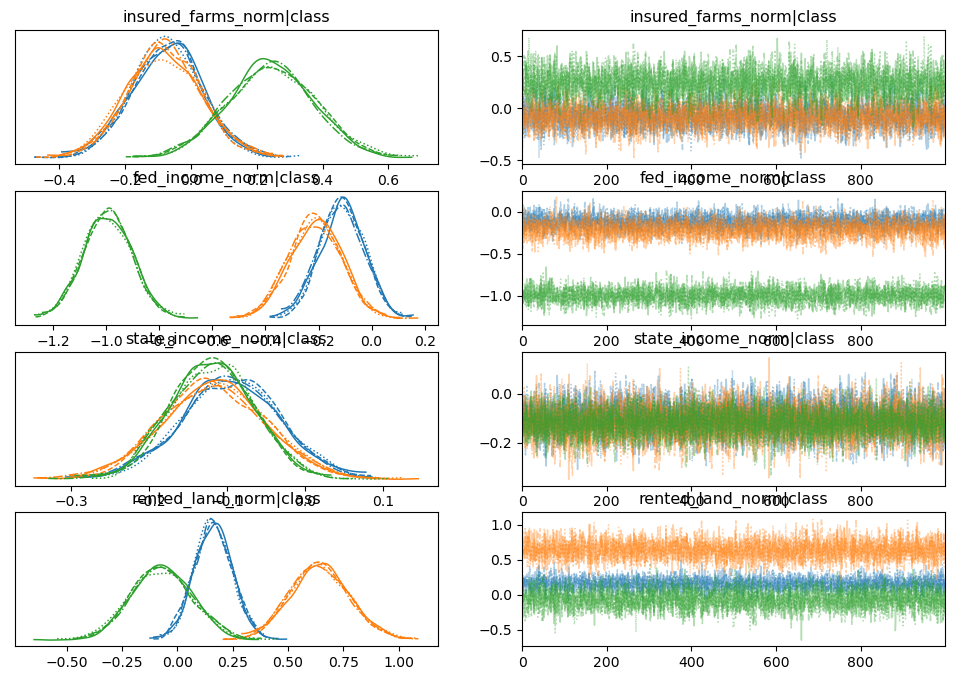

In [20]:
az.plot_trace(trace, var_names=['insured_farms_norm|class','fed_income_norm|class','state_income_norm|class','rented_land_norm|class'], compact=True);

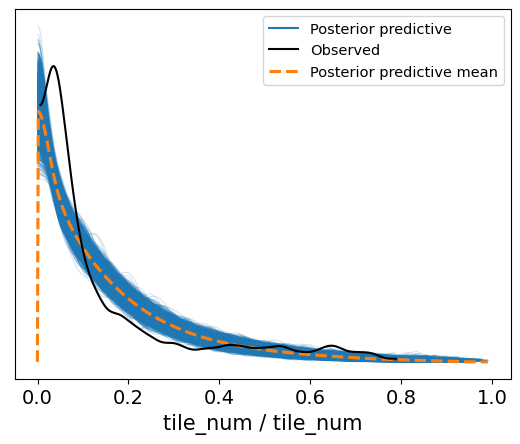

In [21]:
model.predict(trace, kind="pps")
az.plot_ppc(trace);

In [22]:
az.loo(trace)

Computed from 4000 posterior samples and 872 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  1066.57    31.19
p_loo       46.73        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      871   99.9%
 (0.5, 0.7]   (ok)          1    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## Average Marginal Effects 

In [23]:
selvars=['cons',
         'insured_farms_norm','fed_income_norm','state_income_norm','rented_land_norm',
          'machinery_asset_norm','livestockfarm_share_norm',
         'cropland_entropy_norm','cropland_share_norm',
         'erosion_rate_norm','climate_ffp_full_year_norm',
         'climate_prec_growing_season_norm','climate_ffp_z_full_year_norm','climate_prec_z_full_year_norm',
         'year_2017']


varspost= ['1|class','insured_farms_norm|class','fed_income_norm|class','state_income_norm|class',
           'rented_land_norm|class','machinery_asset_norm|class','livestockfarm_share_norm|class',
           'cropland_entropy_norm|class','cropland_share_norm|class',
            'erosion_rate_norm|class','climate_ffp_full_year_norm|class',
            'climate_prec_growing_season_norm|class','climate_ffp_z_full_year_norm|class',
           'climate_prec_z_full_year_norm|class',
           'year_2017|class']

DF1_clean= DF1.copy()
DF1_clean.dropna(axis=0, how='any',subset=['tile_num','insured_farms_norm','fed_income_norm','state_income_norm','rented_land_norm',
          'machinery_asset_norm','livestockfarm_share_norm',
         'cropland_entropy_norm', 'cropland_share_norm',
         'erosion_rate_norm','climate_ffp_full_year_norm','climate_ffp_z_full_year_norm',
         'climate_prec_growing_season_norm','climate_prec_z_full_year_norm',
                                           'year_2017'], inplace=True)


h= 0.001 #scalar
DFame= ame.ame_multilevel(DF1_clean, trace, selvars, varspost, h, 'farm_class', 3, ['Small','Medium', 'Large'])


In [24]:
DFame

,AME,std,CI25,CI97,farm_class
cons,0.105119,1.390153e-17,0.105119,0.105119,Small
insured_farms_norm,-0.006782,3.465345e-03,-0.016601,-0.002175,Small
fed_income_norm,-0.010620,5.426703e-03,-0.025996,-0.003406,Small
state_income_norm,-0.009005,4.601403e-03,-0.022043,-0.002888,Small
rented_land_norm,0.015247,7.791009e-03,0.004891,0.037323,Small
machinery_asset_norm,-0.002715,1.387423e-03,-0.006646,-0.000871,Small
livestockfarm_share_norm,-0.046080,2.354886e-02,-0.112809,-0.014779,Small
cropland_entropy_norm,-0.021529,1.100161e-02,-0.052703,-0.006905,Small
cropland_share_norm,0.018092,9.244644e-03,0.005803,0.044286,Small
erosion_rate_norm,0.011607,5.930835e-03,0.003723,0.028411,Small


In [25]:
mean, lci, uci= r2.Bayesian_Rsquared(DF1_clean, trace, 'tile_num',selvars,varspost, True, 'class', 4, 1000, 3)
print('Mean CI:', meanp)
print('Lower CI:', lcip)
print('Upper CI:', ucip)

Mean CI: 0.5595760766477736
Lower CI: 0.5193972408864052
Upper CI: 0.5952344170136762


### Model comparison

In [26]:
az.compare({"main": trace, "pooled": tracep})#, 'state effects': trace_cc2})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
main,0,1066.566741,46.727912,0.00000,0.711978,31.190492,0.000000,False,log
pooled,1,1032.037331,18.919710,34.52941,0.288022,29.952481,15.837575,False,log


In [27]:
print('Lower Bound: ', 34.52941-15.837575*2.92)
print('Upper Bound: ', 34.52941+15.837575*2.92)


Lower Bound:  -11.716308999999995
Upper Bound:  80.77512899999999
